# Mean reverting strategy based on Bollinger bands Strategy

This notebook answers question 3.5 form the text book Advances in Financial Machine Learning.

3.5 Develop a mean-reverting strategy based on Bollinger bands. For each observation, the model suggests a side, but not a size of the bet.

* (a) Derive meta-labels for ptSl = [0, 2] and t1 where numDays = 1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
* (b) Train a random forest to decide whether to trade or not. Use as features: volatility, seial correlation, and teh crossinmg moving averages.
* (c) What is teh accuracy of prediction from the primary model? (i.e. if the secondary model does not filter the bets) What are the precision, recall and FI-scores?
* (d) What is teh accuracy of prediction from the primary model? What are the precision, recall and FI-scores?


In [30]:
# Import the Hudson and Thames MlFinLab package
import mlfinlab as ml

In [31]:
import numpy as np
import pandas as pd
import pyfolio as pf
import timeit

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

### Read in Data
We are using the dollar bars based off of the high quality HFT data we purchased. There is a sample of bars available in this branch as well. 

In [32]:
# Read in data
data = pd.read_csv('../Sample-Data//dollar_bars.csv')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

---
### Define helper functions

In [33]:
# Compute RSI
def relative_strength_index(df, n):
        """Calculate Relative Strength Index(RSI) for given data.
        https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
        
        :param df: pandas.DataFrame
        :param n: 
        :return: pandas.DataFrame
        """
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
        RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
        # df = df.join(RSI)
        return RSI

def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

In [34]:
def bbands(close_prices, window, no_of_stdev):
    # rolling_mean = close_prices.rolling(window=window).mean()
    # rolling_std = close_prices.rolling(window=window).std()
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

---
### Fit a Primary Model: Mean-reverting based on Bollinger bands
Based on the mean-reverting Bollinger band strategy.


In [35]:
# compute bands
window = 50
data['avg'], data['upper'], data['lower'] = bbands(data['close'], window, no_of_stdev=1.5)
data.sample(10)

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower
date_time,,,,,,,,,,
2016-06-16 18:10:43.649,2056.25,2060.00,2056.25,2060.00,34134,70268251.00,3516,2056.241326,2067.684954,2044.797698
2016-09-08 16:52:44.880,2179.75,2180.75,2179.25,2180.00,32262,70329468.00,2913,2181.098721,2184.776804,2177.420638
2016-08-04 19:46:54.363,2158.75,2160.50,2158.50,2159.75,32413,70002460.00,2255,2157.688104,2162.837972,2152.538235
2015-01-28 15:33:23.302,2031.00,2032.25,2027.50,2028.25,34479,70003190.75,12512,2031.246936,2041.619900,2020.873971
2016-01-05 20:15:29.923,2006.00,2008.75,2004.50,2008.50,34893,70009780.50,4205,2003.882396,2017.013669,1990.751123
2016-06-15 08:05:17.718,2069.25,2071.25,2068.25,2068.75,33845,70047877.75,5584,2064.509639,2073.588907,2055.430371
2015-12-21 15:51:42.343,2011.25,2012.50,2007.50,2007.75,34859,70076898.75,4602,2009.151522,2024.818696,1993.484348
2015-07-31 19:59:56.409,2098.75,2099.00,2098.25,2098.75,33355,70002298.75,535,2099.891148,2106.192033,2093.590263
2015-09-30 16:07:32.091,1895.50,1898.00,1893.00,1893.00,36939,70034175.75,4595,1891.809610,1911.168876,1872.450344


In [36]:
# Compute RSI
rsi_df = get_rsi(data, window=14)
data['rsi'] = pd.Series(data=rsi_df.values, index=data.index)

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

---
### Fit a Primary Model: Bollinger Band Mean-Reversion

In [37]:
# Compute sides
data['side'] = np.nan 

long_signals = (data['close'] <= data['lower']) 
short_signals = (data['close'] >= data['upper']) 

data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

print(data.side.value_counts())

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)

 1.0    1251
-1.0    1085
Name: side, dtype: int64


In [38]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

In [39]:
print(data.side.value_counts())

 1.0    1251
-1.0    1085
Name: side, dtype: int64


### Filter Events: CUSUM Filter
Predict what will happen when a CUSUM event is triggered. Use the signal from the MAvg Strategy to determine the side of the bet.

In [40]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=data['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(data['close'], threshold=daily_vol['2011-09-01':'2018-01-01'].mean() * 0.1)

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)

In [41]:
pt_sl = [0, 2]
min_ret = 0.0005
triple_barrier_events = ml.labeling.get_events(close=data['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=2,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=data['side'])

2023-05-08 05:05:25.438509 100.0% apply_pt_sl_on_t1 done after 0.05 minutes. Remaining 0.0 minutes.
c:\Users\sms20\miniconda3\lib\site-packages\mlfinlab\util\multiprocess.py:119: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(i)
c:\Users\sms20\miniconda3\lib\site-packages\mlfinlab\util\multiprocess.py:119: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(i)


In [42]:
labels = ml.labeling.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

 1.0    727
-1.0    580
Name: side, dtype: int64

---
### Results of Primary Model:


In [43]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       572
           1       0.56      1.00      0.72       735

    accuracy                           0.56      1307
   macro avg       0.28      0.50      0.36      1307
weighted avg       0.32      0.56      0.40      1307

Confusion Matrix
[[  0 572]
 [  0 735]]

Accuracy
0.5623565416985463


c:\Users\sms20\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sms20\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sms20\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**A few takeaways**
* There is an imbalance in the classes - far more are classified as "no trade"
* Meta-labeling says that there are many false-positives  
* the sklearn's confusion matrix is [[TN, FP][FN, TP]] 

---
## Fit a Meta Model
Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)

Create the following features: 
* Volatility
* Serial Correlation
* The returns at the different lags from the serial correlation
* The sides from the SMavg Strategy

In [44]:
raw_data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower,rsi,side
date_time,,,,,,,,,,,,
2015-01-02 15:39:14.826,2055.00,2055.75,2051.25,2051.75,34093,70002159.25,11391,2059.642749,2066.077469,2053.208029,30.0,NaN
2015-01-02 15:43:25.099,2051.75,2051.75,2047.00,2047.75,34162,70005202.25,11490,2058.609174,2066.654918,2050.563430,21.0,1.0
2015-01-02 15:48:54.420,2047.75,2049.50,2045.50,2048.25,34192,70013855.25,11815,2057.749862,2066.623663,2048.876061,18.0,1.0
2015-01-02 15:57:26.907,2048.25,2051.75,2047.50,2050.50,34159,70006929.50,12459,2057.173673,2066.197362,2048.149984,31.0,1.0
2015-01-02 16:07:49.314,2050.50,2051.00,2045.50,2045.50,34208,70061993.75,13503,2056.281805,2066.177348,2046.386262,27.0,NaN


### Features

In [45]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 7
slow_window = 15

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()


In [46]:
# Add Trending signals
raw_data['sma'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'sma'] = 1
raw_data.loc[short_signals, 'sma'] = -1

In [47]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['close'] <= raw_data['lower'] 
short_signals = raw_data['close'] >= raw_data['upper'] 

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [48]:
# Remove look ahead bias
raw_data = raw_data.shift(1)

#### Now get the data at the specified events

In [49]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['avg', 'upper', 'lower', 'open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']
X.head()

,rsi,side,log_ret,mom1,mom2,mom3,mom4,mom5,volatility,autocorr_1,autocorr_2,autocorr_3,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5,sma
2015-01-05 14:30:57.874,26.0,1.0,0.000000,0.000000,-0.002937,-0.002937,-0.003790,-0.003303,NaN,NaN,NaN,NaN,NaN,NaN,-0.002941,0.000000,-0.000856,0.000489,0.001469,-1.0
2015-01-05 14:44:56.036,29.0,1.0,-0.001474,-0.001473,-0.002574,-0.001473,-0.001473,-0.004405,NaN,NaN,NaN,NaN,NaN,NaN,-0.001104,0.001104,0.000000,-0.002941,0.000000,-1.0
2015-01-05 14:54:26.286,26.0,1.0,-0.001843,-0.001842,-0.000737,-0.002209,-0.003310,-0.002209,NaN,NaN,NaN,NaN,NaN,NaN,0.001106,-0.001474,-0.001104,0.001104,0.000000,-1.0
2015-01-05 15:01:57.494,19.0,1.0,-0.000493,-0.000493,-0.001599,-0.003438,-0.002335,-0.003805,NaN,NaN,NaN,NaN,NaN,NaN,-0.001108,-0.001843,0.001106,-0.001474,-0.001104,-1.0
2015-01-05 15:07:29.012,17.0,1.0,-0.001356,-0.001355,-0.001847,-0.002952,-0.004788,-0.003687,NaN,NaN,NaN,NaN,NaN,NaN,-0.000493,-0.001108,-0.001843,0.001106,-0.001474,-1.0


### Fit a model

In [50]:
# Split data into training, validation and test sets
X_training_validation = X['2011-09-01':'2018-01-01']
y_training_validation = y['2011-09-01':'2018-01-01']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)

In [51]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

1    569
0    476
Name: bin, dtype: int64

In [52]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

0    476
1    476
Name: bin, dtype: int64

In [53]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

In [54]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [57]:
X_train = X_train.fillna(0)

In [58]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.50837688 0.58166796 0.60547454 0.61785891 0.61551091 0.62345526
 0.62045406 0.51828967 0.61983617 0.63526587 0.64531107 0.64813572
 0.65186074 0.65094273 0.52121143 0.61907704 0.64350152 0.66001695
 0.67099781 0.67994845 0.67788292 0.5368618  0.63703128 0.67504943
 0.69380693 0.69896194 0.70701222 0.70796554 0.5367294  0.6809106
 0.73940753 0.75195961 0.76165172 0.76836029 0.76634772]
256 7 42


In [59]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=256,
                       random_state=42)

#### Training Metrics

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       476
           1       0.95      0.89      0.92       476

    accuracy                           0.92       952
   macro avg       0.92      0.92      0.92       952
weighted avg       0.92      0.92      0.92       952

Confusion Matrix
[[454  22]
 [ 51 425]]

Accuracy
0.9233193277310925


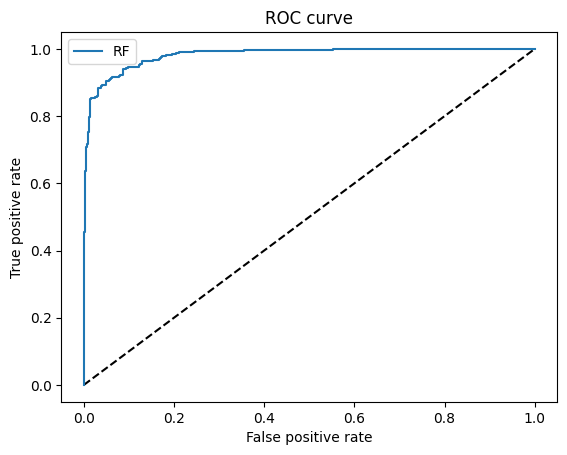

In [60]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Validation Metrics

              precision    recall  f1-score   support

           0       0.35      0.70      0.46        96
           1       0.58      0.24      0.34       166

    accuracy                           0.41       262
   macro avg       0.46      0.47      0.40       262
weighted avg       0.49      0.41      0.39       262

Confusion Matrix
[[ 67  29]
 [126  40]]

Accuracy
0.4083969465648855


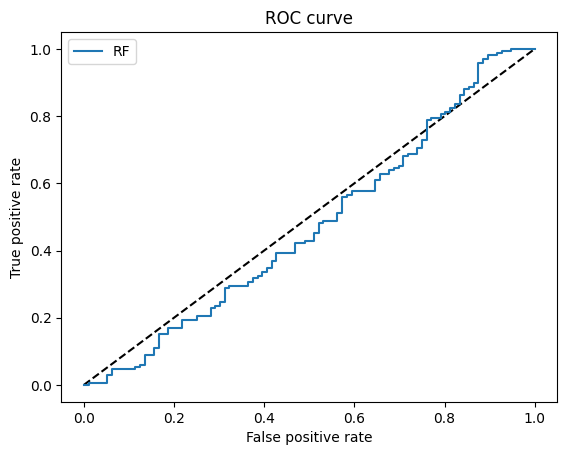

In [61]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [64]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

start = primary_forecast.index.get_loc('2016-08-01 10:31:44.455000')
end = primary_forecast.index.get_loc('2016-12-28 19:43:32.240') + 1

subset_prim = primary_forecast[start:end]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        92
           1       0.61      1.00      0.76       146

    accuracy                           0.61       238
   macro avg       0.31      0.50      0.38       238
weighted avg       0.38      0.61      0.47       238

Confusion Matrix
[[  0  92]
 [  0 146]]

Accuracy
0.6134453781512605


c:\Users\sms20\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sms20\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sms20\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


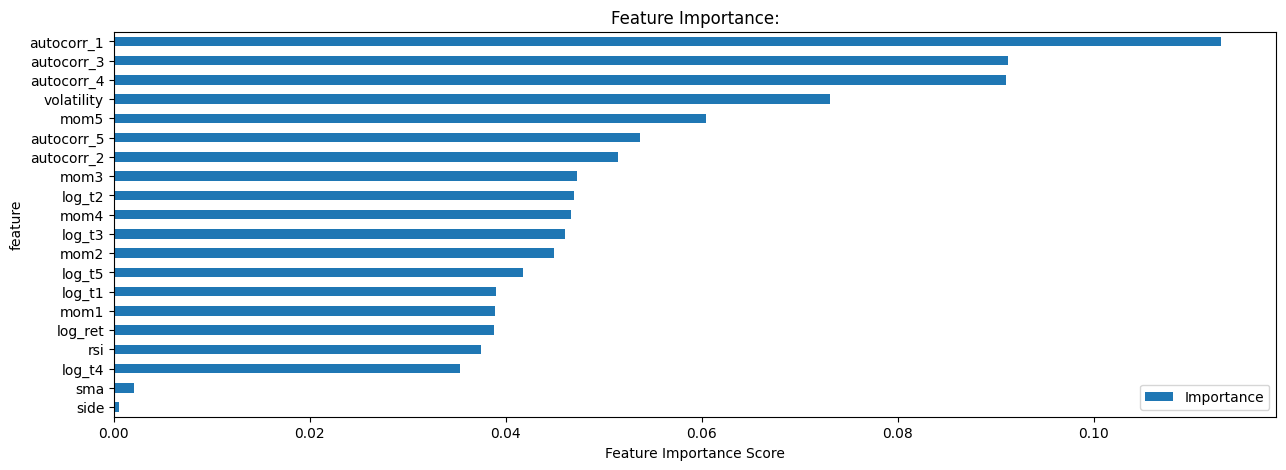

In [65]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

Note how low the side is ranked.

---
## Performance Tear Sheets (In-sample)

In [66]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

In [67]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [68]:
test_dates = X_validate.index

base_rets = labels.loc[test_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(primary_model_rets)

c:\Users\sms20\miniconda3\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
c:\Users\sms20\miniconda3\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
c:\Users\sms20\miniconda3\lib\site-packages\pyfolio\plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2016-07-15
End date,2016-12-28
Total months,5
,Backtest
Annual return,380.6%
Cumulative returns,109.9%
Annual volatility,111.8%
Sharpe ratio,1.80
Calmar ratio,26.28
Stability,0.80
Max drawdown,-14.5%


In [69]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_meta_rets, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model'] = perf_stats_all

# pf.create_returns_tear_sheet(meta_returns, benchmark_rets=None)
pf.show_perf_stats(daily_meta_rets)

c:\Users\sms20\miniconda3\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
c:\Users\sms20\miniconda3\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
c:\Users\sms20\miniconda3\lib\site-packages\pyfolio\plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2016-07-15
End date,2016-12-28
Total months,5
,Backtest
Annual return,4.8%
Cumulative returns,2.2%
Annual volatility,11.9%
Sharpe ratio,0.45
Calmar ratio,0.44
Stability,0.16
Max drawdown,-10.8%


---
## Perform out-of-sample test

In [70]:
# extarct data for out-of-sample (OOS)
X_oos = X['2018-01-02':]
y_oos = y['2018-01-02':]

In [71]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_oos)[:, 1]
y_pred = rf.predict(X_oos)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 20)) while a minimum of 1 is required by RandomForestClassifier.

In [ ]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

subset_prim = primary_forecast['2018-01-02':]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       749
           1       0.17      1.00      0.29       151

   micro avg       0.17      0.17      0.17       900
   macro avg       0.08      0.50      0.14       900
weighted avg       0.03      0.17      0.05       900

Confusion Matrix
[[  0 749]
 [  0 151]]

Accuracy
0.16777777777777778


/home/jackal08/anaconda3/envs/test_pip/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
## Performance Tear Sheets (Out-of-sample)

In [ ]:
test_dates = X_oos.index

base_rets_oos = labels.loc[test_dates, 'ret']
primary_model_rets_oos = get_daily_returns(base_rets_oos)

# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets_oos, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Primary Model OOS'] = perf_stats_all


# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(primary_model_rets_oos)

Start date,2018-01-04
End date,2019-01-28
Total months,13
,Backtest
Annual return,17.7%
Cumulative returns,19.7%
Annual volatility,95.0%
Sharpe ratio,0.65
Calmar ratio,0.29
Stability,0.16
Max drawdown,-61.9%


Start date,2018-01-04
End date,2019-01-28
Total months,13
,Backtest
Annual return,35.3%
Cumulative returns,39.6%
Annual volatility,56.7%
Sharpe ratio,0.82
Calmar ratio,0.96
Stability,0.63
Max drawdown,-36.8%


/home/jackal08/anaconda3/envs/test_pip/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,36.78,2018-11-09,2018-12-19,NaT,NaN
1,33.98,2018-01-29,2018-02-05,2018-05-08,72
2,6.94,2018-10-09,2018-10-10,2018-10-11,3
3,6.87,2018-10-17,2018-10-24,2018-10-29,9
4,3.11,2018-06-22,2018-06-25,2018-06-27,4


/home/jackal08/anaconda3/envs/test_pip/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


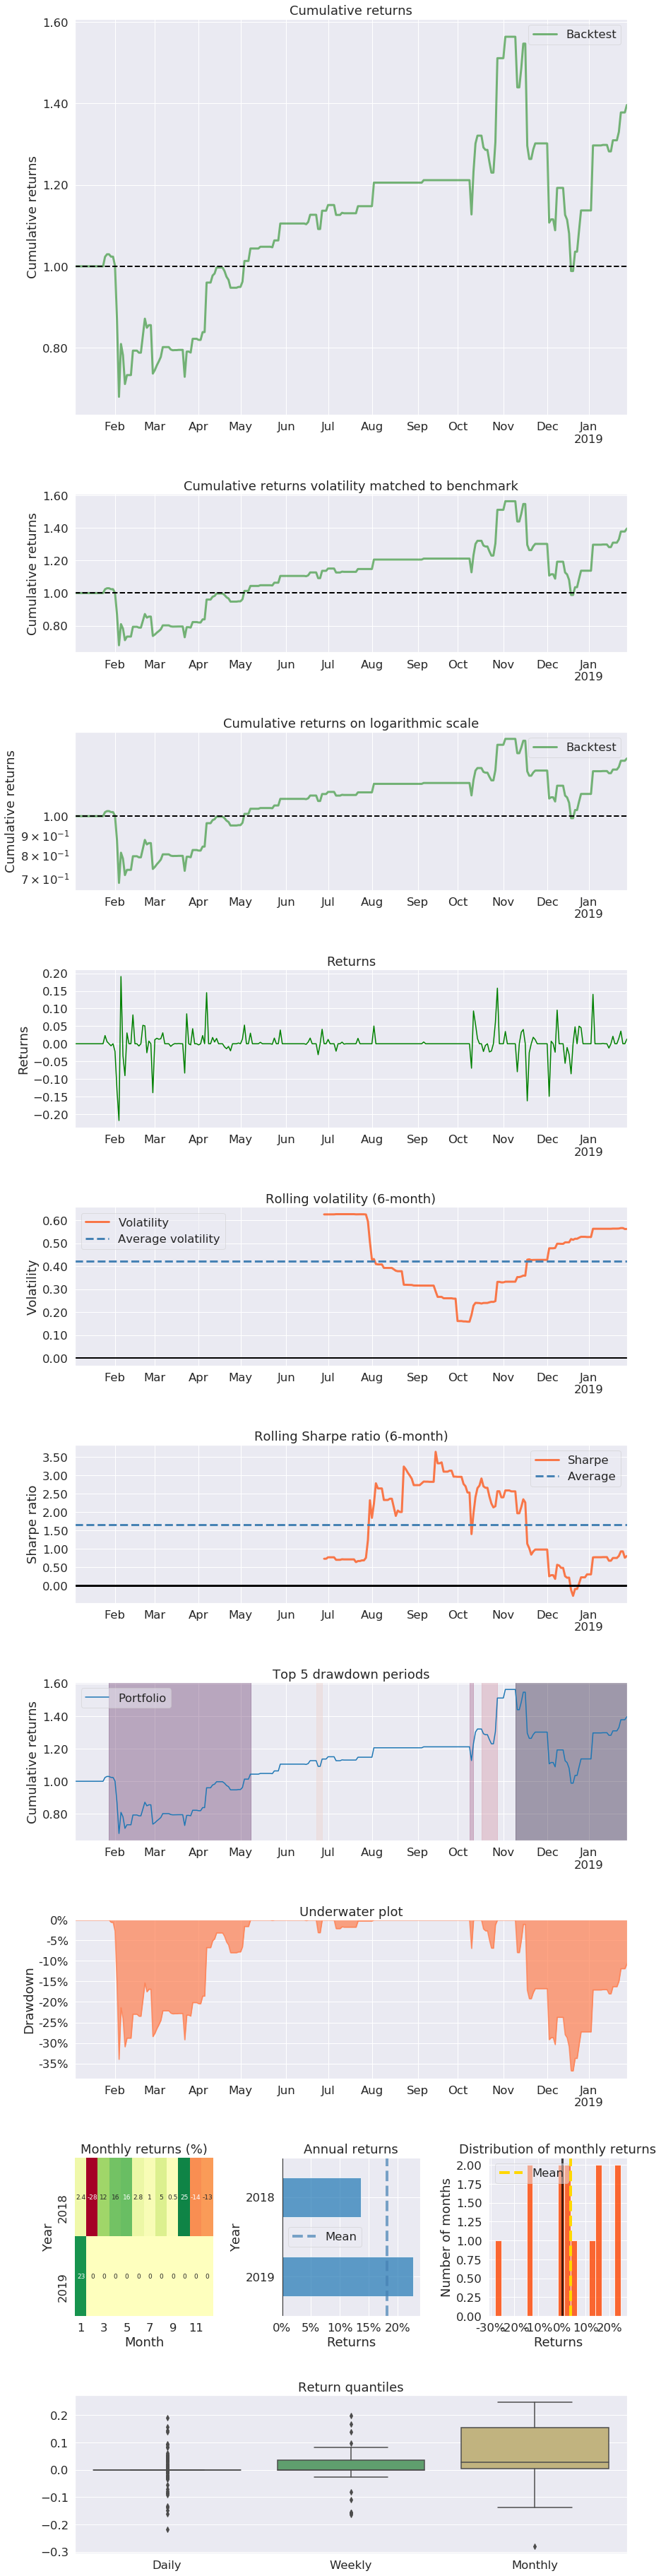

In [ ]:
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_all = perf_func(returns=daily_rets_meta, 
                           factor_returns=None, 
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

perf_stats_df['Meta Model OOS'] = perf_stats_all

pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

---
## Conclusion
There are a few takeaways from the Bollinger bands mean-reverting strategy:
1. In out-of-sample tests, the meta-model out-performs the primary model in all key statistics:
    * Annualized returns: 17.7% vs. 35.3%
    * Annualized volatility: 95% vs. 40%
    * Sharpe ratio: 0.65 vs. 0.82 
2. In all cases the meta-model (one with meta-labeling) decreases annualized volatility, maximum drawdown and increases Sharpe ratio compared to the primary model     
